## The usual imports

In [1]:
# the usual imports
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

## Loading data

In [2]:
# importing my library
from parser.parser import parse_image_label_pairs

In [3]:
# setting up the data
# this file follows the naming convention of darknet
# it is a list of images
# and for each image, there should be a file with labels at ../labels/image_name.txt
train_path = "/home/lars/data/darknet/VOC/train.txt"

# the parser goes through that list and creates a list of filename pairs
image_label_pairs = parse_image_label_pairs(train_path)

pair_index = 1
image_label_pairs[pair_index]

('/home/lars/data/darknet/VOC/VOCdevkit/VOC2007/JPEGImages/000017.jpg',
 '/home/lars/data/darknet/VOC/VOCdevkit/VOC2007/labels/000017.txt')

In [4]:
# the jpg is simply an image
# the txt file contains a list of bounding boxes
# each bounding box is given as:
# label x_center y_center x_width y_width
# all coordinates and widths are normalized to [0,1]

# go through the annotations and store the boxes
annotations = []
with open(image_label_pairs[pair_index][1]) as file:
    for line in file:
        numbers = [float(number) for number in line.strip().split(" ")]
        annotations.append(numbers)
        
    
# in this case it's a single box
# the label is 6 and the object is centered in the center of the image
print(annotations)

[[14.0, 0.483333333333, 0.358516483516, 0.195833333333, 0.376373626374], [12.0, 0.513541666667, 0.568681318681, 0.652083333333, 0.708791208791]]


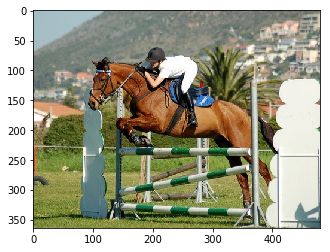

In [5]:
# lets take a look at the corresponding image
image = cv2.imread(image_label_pairs[pair_index][0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

## Plotting the bounding boxes

Attention: The annotations are [label, x, y, width, height]. The x coordinate corresponds to the width and the y coordinate to the height. So x goes left-right and y goes up-down.

For plotting, this is rather confusing since for numpy, the x coordinates correspond to up-down.

We could also use opencv. But then we can't plot the rectangle as x,y,w,h. For opencv we have to provide the corners.

In [6]:
# some helper functions
# they can write rectangles on numpy arrays
from utils.plot_utils import draw_rect

In [7]:
# let's plot the annotations onto the image
canvas = image.copy()

for annotation in annotations:
    label = annotation[0]
    rect = annotation[1:]
    y, x, dy, dx = rect
    rect = (x, y, dx, dy)
    
    draw_rect(canvas, rect, color=(255, 0, 0), thickness=5)

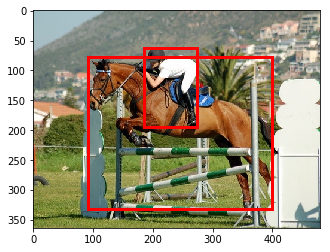

In [8]:
plt.imshow(canvas)
plt.show()

## Augmenting the image

In order to augment the image, we apply random transformations: The image is shifted, rotated, zoomed, maybe flipped and we apply HSV shifts in the color channels.

The exact same transformations need to be applied to the bounding boxes. To do that we convert the bounding boxes to vertices and apply the transformation matrices to these vertices, too.
After that we recreate a bounding box from the transformed vertices.

The interesting code is contained in the augment() function.
Once the annotations are loaded and parsed, the actual augmentation becomes just one line.

In [35]:
# to parse annotations
from parser.parser import parse_labels

# to convert the format of bounding box annotations
from utils.object import wh_to_minmax, minmax_to_wh

# to apply random augmentations to the object
from augmentations import augment

In [36]:
# let's specify some properties of our neural network
in_x = 400
in_y = 400

In [40]:
# sample a (random) image from the list of annotated images
pair = image_label_pairs[pair_index]

# load the image and resize it to input dimensions
# the bounding boxes are not affected by the resizing, since they are normalized to [0,1]
img = cv2.imread(pair[0])
img = cv2.resize(img, (in_y, in_x))

# load the annotations
objects = parse_labels(pair[1])

# for the augmentation, we work on the vertices of the bounding box
# so now we convert to the format used by opencv and tensorflow
# a bounding box is now encoded by [x_min, y_min, x_max, y_max]
# this is not the usual layout for loss formulations like multibox
# after the augmentations we will undo this again
objects_minmax = wh_to_minmax(objects)

# apply random augmentations
img, objects_minmax = augment(img, objects_minmax)

# convert back to the format desired by yolo
objects = minmax_to_wh(objects_minmax)

# now you can preprocess your image for the network
# normalizing color channels, mean shifts, etc
# we want to plot it, so let's convert it to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [41]:
# let's plot the annotations onto the image
canvas = img.copy()

for annotation in objects:
    label = annotation[0]
    rect = annotation[1:]
    draw_rect(canvas, rect, color=(0,255,0), thickness=2)

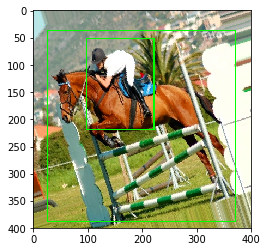

In [42]:
plt.imshow(canvas)
plt.show()